## 사망사고 분류 모델 만들기

In [72]:
import pandas as pd
import numpy as np
#데이터 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({'font.family':'MalgunGothic'})
mpl.rc('axes', unicode_minus=False)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#머신러닝 성능 지표 관련 라이브러리
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score,recall_score
from sklearn.metrics import precision_recall_curve


In [73]:

df = pd.read_csv(r"C:\Users\thdfy\OneDrive\바탕 화면\Datamining_Teampro\data\2022서울시교통사고현황-데이터셋.csv",encoding = 'euc-kr')
test = pd.read_csv(r"C:\Users\thdfy\OneDrive\바탕 화면\Datamining_Teampro\data\2023서울시교통사고현황-데이터셋.csv",encoding = 'euc-kr')


In [74]:
df['중상자수'] = df['중상자수'].apply(lambda x: 1 if x >= 2 else x)


In [75]:
print(df.isnull().sum())

사고번호            0
사고일시            0
요일              0
시군구             0
사고내용            0
사망자수            0
중상자수            0
경상자수            0
부상신고자수          0
사고유형            0
법규위반            0
노면상태            0
기상상태            0
도로형태            0
가해운전자 차종        0
가해운전자 성별        0
가해운전자 연령        0
가해운전자 상해정도      0
피해운전자 차종      993
피해운전자 성별      993
피해운전자 연령      993
피해운전자 상해정도    993
ECLO            0
dtype: int64


In [76]:
df.dropna(inplace=True)

In [77]:
label='사고내용'
print(df[label].value_counts())
counts= list(df[label].value_counts())
ratio = counts[1]/(counts[0]+counts[1]+counts[2]+counts[3])
print(f'전체 사고중 중상사고의 비율은 {str(ratio * 100)}% 입니다')

사고내용
경상사고      23723
중상사고       6940
부상신고사고     1862
사망사고        180
Name: count, dtype: int64
전체 사고중 중상사고의 비율은 21.219996942363554% 입니다


### 데이터 전처리 PART

In [78]:

# 불필요해보이는 컬럼 제거
'''
가해운전자/피해운전자 상해정도,사망자수,중상자수,경상자수,부상신고자수,사고내용은 중상사고여부에 종합하여 정보가 담기고,
차대차인지 차대사람인지에 대한 정보가 사고유형에 담기므로 가해운전자 차종과 피해운전자 차종에서 삭제하였음
요일은 주말과 평일로 통합하였음
'''
df.drop(['사고번호', '시군구', '사망자수',  '경상자수', '부상신고자수', '노면상태',
            '가해운전자 상해정도', '피해운전자 상해정도', '사고내용', '가해운전자 차종', '피해운전자 차종'], axis=1, inplace=True)

##시간에 따른 시계가 교통사고의 요인중 하나일 수 있으므로 발생년월일시에서 시간만 떼어 새로운 컬럼으로 만듬
time_lst = list(df['사고일시'])
hour_lst = []
for time in time_lst:
    hour_lst.append((str(time)[-3:-1]))
df['사고시각'] = hour_lst

# 사고일시 컬럼은 삭제
df.drop(['사고일시'], axis=1, inplace=True)

# 사고시각에서 22시부터 06시까지를 야간으로, 그외 시간을 야간X로 이진분류하기
index2 = df['사고시각'] == '22', '23', '24', '1', '2', '3', '4', '5', '6'
df['야간여부'] = index2[0]
df.drop(['사고시각'], axis=1, inplace=True)

# 주말과 평일로 이진분류하기
index3 = df['요일'] == '토요일', '일요일'
df['주말여부'] = index3[0]
df.drop('요일', axis=1, inplace=True)

# 남성과 여성을 1과 0으로 이진분류하기
index4 = df['가해운전자 성별'] == '남'
df['가해운전자 성별- 여성0 남성1'] = index4
df.drop('가해운전자 성별', axis=1, inplace=True)

index5 = df['피해운전자 성별'] == '남'
df['피해운전자 성별- 여성0 남성1'] = index5
df.drop('피해운전자 성별', axis=1, inplace=True)

# 중상사고여부와 야간여부,주말여부, 성별을 boolean에서 정수형으로 변환하기
df['야간여부'] = df['야간여부'].astype(int)
df['주말여부'] = df['야간여부'].astype(int)
df['가해운전자 성별- 여성0 남성1'] = df['가해운전자 성별- 여성0 남성1'].astype(int)
df['피해운전자 성별- 여성0 남성1'] = df['피해운전자 성별- 여성0 남성1'].astype(int)

# 연령 전처리하기
# 미분류, 98세 이상 데이터 삭제
idx = df[df['가해운전자 연령'] == '98세 이상'].index
df.drop(idx, inplace=True)
idx = df[df['피해운전자 연령'] == '98세 이상'].index
df.drop(idx, inplace=True)

idx2 = df[df['가해운전자 연령'] == '미분류'].index
df.drop(idx2, inplace=True)
idx2 = df[df['피해운전자 연령'] == '미분류'].index
df.drop(idx2, inplace=True)

# 나이 컬럼: 숫자단위만 뽑기
suspect_lst = list((df['가해운전자 연령']))
suspect_old = []
for old in suspect_lst:
    suspect_old.append((old)[:-1])

df['가해운전자 연령'] = suspect_old

victim_lst = list(df['피해운전자 연령'])
victim_old = []
for old in victim_lst:
    victim_old.append((old)[:-1])
df['피해운전자 연령'] = victim_old

# 데이터 자료형 변환: 문자열-> 정수형
df['가해운전자 연령'] = df['가해운전자 연령'].astype('int')
df['피해운전자 연령'] = df['피해운전자 연령'].astype('int')

# 나이 단위 정규화하기
olds = df[['피해운전자 연령', '가해운전자 연령']]
scaler = StandardScaler()
scaled_olds = scaler.fit_transform(olds)
df[['피해운전자 연령', '가해운전자 연령']] = scaled_olds
df.rename({'피해운전자 연령': '피해운전자 연령(정규화 됨)', '가해운전자 연령': '가해운전자 연령(정규화 됨)'}, axis=1, inplace=True)

# y(종속변수)가 데이터프레임 끝에 오도록 재배치하기
df = df.reindex(columns=['주말여부', '야간여부', '사고유형', '법규위반', '기상상태', '도로형태',
                            '가해운전자 성별- 여성0 남성1', '가해운전자 연령(정규화 됨)',
                            '피해운전자 성별- 여성0 남성1', '피해운전자 연령(정규화 됨)', '중상자수'])

In [79]:
df.shape

(31940, 11)

In [80]:
df['중상자수'].value_counts()

중상자수
0    25061
1     6879
Name: count, dtype: int64

In [81]:
features=['사고유형','법규위반','기상상태','도로형태']
df= pd.get_dummies(data=df,columns=features,prefix=features)

### 데이터 분할

In [82]:
from sklearn.model_selection import train_test_split

test_size = 0.2

# 독립변수와 종속변수 분리
X = df.drop(['중상자수'], axis=1)
y = df['중상자수']

# stratify 파라미터를 사용하여 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

print(f'X_train의 크기는 {len(X_train)}, y_train의 크기는 {len(y_train)}')
print(f'X_test의 크기는 {len(X_test)}, y_test의 크기는 {len(y_test)}')


X_train의 크기는 25552, y_train의 크기는 25552
X_test의 크기는 6388, y_test의 크기는 6388


#### 평가함수 정의

In [83]:
def evaluate_model(y_test,y_pred,y_pred_proba):
    #모델 평가
    roc_val= roc_auc_score(y_test,y_pred_proba)
    recall_val= recall_score(y_test,y_pred)
    accuracy_val= accuracy_score(y_test,y_pred)
    precision_val= precision_score(y_test,y_pred)

    print('\n--------------------------------------')
    print(f'ROC_AUC는 {roc_val} 입니다')
    print(f'recall_score는 {recall_val} 입니다')
    print(f'precision_score는 {precision_val} 입니다')
    print(f'accuracy_score는 {accuracy_val} 입니다')
    print('--------------------------------------')

    print(f'전체 테스트셋 데이터 에서 1(사망)으로 예측한 비율은 {y_pred.sum()/len(y_pred)}입니다')

In [84]:
def feature_importance(clf,X_train):
    # feature_importance를 배열형태로 반환
    ft_importance_values = clf.feature_importances_
    max_val= max(ft_importance_values)
    scaled_ft_importance_values= ft_importance_values/max_val
    print(ft_importance_values)

    # 정렬과 시각화를 쉽게 하기 위해 series 전환
    ft_series = pd.Series(scaled_ft_importance_values, index = X_train.columns)
    ft_top20 = ft_series.sort_values(ascending=False)[:20]

    # 시각화
    plt.figure(figsize=(8,6))
    plt.xticks(np.arange(0,1.05,0.05) ,rotation='45')
    plt.title('Feature Importance Top 20')
    sns.barplot(x=ft_top20, y=ft_top20.index)
    plt.show()

In [85]:
def precision_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds= precision_recall_curve(y_test,pred_proba_c1)
    #threshold array와 이 threshold에 따른 정밀도, 재현율을 반환한다
    precisions, recalls, thresholds= precision_recall_curve(y_test,pred_proba_c1)

    #x축을 threshold값으로, y축을 정밀도, 재현율 값으로 각각 plot을 수행한다. 정밀도는 점선으로 표기한다
    plt.figure(figsize=(8,6))
    threshold_boundary= thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

    #thresholds 값 X축의 scale을 0.1 단위로 변경한다
    start, end= plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    #x축, y축, label과 legend, 그리고 grid를 설정한다
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall Value')
    plt.legend(loc='best')
    plt.show()


In [86]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = r"C:\Windows\Fonts\malgun.ttf"  # 정확한 파일명으로 변경
fontprop = fm.FontProperties(fname=font_path)

# Matplotlib의 기본 폰트를 '맑은 고딕'으로 설정합니다.
plt.rc('font', family=fontprop.get_name())

# 한글 폰트가 깨질 경우를 대비하여 유니코드 마이너스를 사용하지 않도록 설정합니다.
plt.rcParams['axes.unicode_minus'] = False

Gradient Boosting Classifier - Precision and Recall Curve


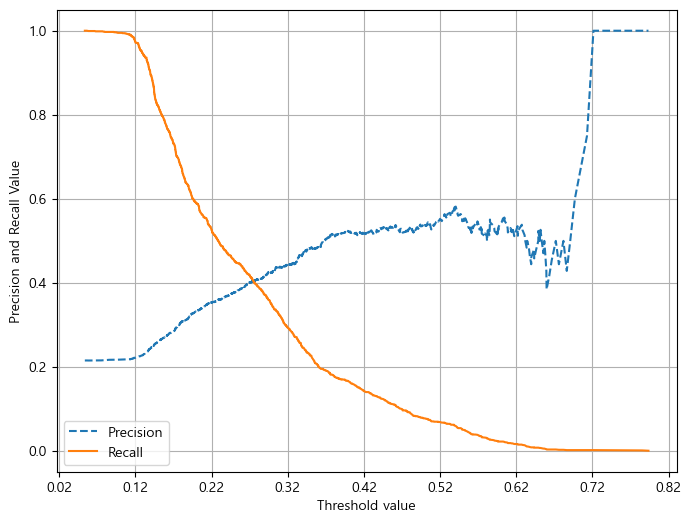

Support Vector Machine - Precision and Recall Curve


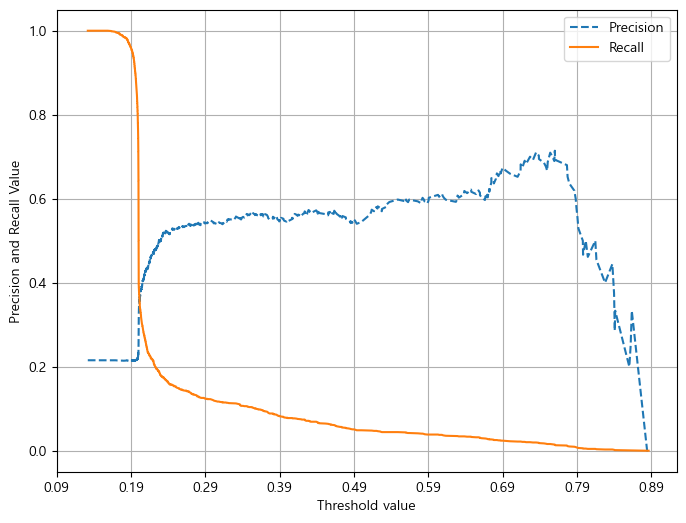

Gradient Boosting Classifier
Accuracy: 0.7867877269881027
              precision    recall  f1-score   support

           0       0.79      0.98      0.88      5012
           1       0.54      0.08      0.13      1376

    accuracy                           0.79      6388
   macro avg       0.67      0.53      0.51      6388
weighted avg       0.74      0.79      0.72      6388

Support Vector Machine
Accuracy: 0.7866311834690044
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      5012
           1       0.55      0.05      0.09      1376

    accuracy                           0.79      6388
   macro avg       0.67      0.52      0.48      6388
weighted avg       0.74      0.79      0.71      6388



In [88]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
import matplotlib.pyplot as plt

# 데이터 분할
test_size = 0.2
X = df.drop(['중상자수'], axis=1)
y = df['중상자수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

# Gradient Boosting Classifier 모델 학습
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)

# 예측 확률 계산
pred_proba_gb = gb_clf.predict_proba(X_test)[:, 1]

# Support Vector Machine (SVM) 모델 학습
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

# 예측 확률 계산
pred_proba_svm = svm_clf.predict_proba(X_test)[:, 1]

# 정밀도-재현율 곡선 시각화 함수
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # x축을 threshold 값으로, y축을 정밀도, 재현율 값으로 각각 plot 수행
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='Precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='Recall')

    # thresholds 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall Value')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Gradient Boosting Classifier의 정밀도-재현율 곡선
print("Gradient Boosting Classifier - Precision and Recall Curve")
precision_recall_curve_plot(y_test, pred_proba_gb)

# SVM의 정밀도-재현율 곡선
print("Support Vector Machine - Precision and Recall Curve")
precision_recall_curve_plot(y_test, pred_proba_svm)

# 모델 평가
print("Gradient Boosting Classifier")
y_pred_gb = gb_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb)}")
print(classification_report(y_test, y_pred_gb))

print("Support Vector Machine")
y_pred_svm = svm_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))


In [89]:
from sklearn.metrics import precision_recall_curve

def adjust_threshold(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # 최적의 threshold 선택 (예: F1-score를 최대화하는 임계값)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    best_threshold = thresholds[np.argmax(f1_scores)]

    return best_threshold

# 모델 훈련 후 임계값 조정
best_threshold_gb = adjust_threshold(gb_clf, X_test, y_test)
best_threshold_svm = adjust_threshold(svm_clf, X_test, y_test)

# 새로운 임계값을 적용한 예측
y_pred_gb_new = (gb_clf.predict_proba(X_test)[:, 1] >= best_threshold_gb).astype(int)
y_pred_svm_new = (svm_clf.predict_proba(X_test)[:, 1] >= best_threshold_svm).astype(int)

# 성능 평가
print("Gradient Boosting Classifier (Adjusted Threshold)")
print(classification_report(y_test, y_pred_gb_new))

print("Support Vector Machine (Adjusted Threshold)")
print(classification_report(y_test, y_pred_svm_new))


C:\Users\thdfy\AppData\Local\Temp\ipykernel_19680\3782460952.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


Gradient Boosting Classifier (Adjusted Threshold)
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      5012
           1       0.35      0.55      0.43      1376

    accuracy                           0.68      6388
   macro avg       0.60      0.63      0.60      6388
weighted avg       0.75      0.68      0.70      6388

Support Vector Machine (Adjusted Threshold)
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      5012
           1       0.00      0.00      0.00      1376

    accuracy                           0.78      6388
   macro avg       0.39      0.50      0.44      6388
weighted avg       0.62      0.78      0.69      6388



#### 모델링1 : imblance data이기 때문에 Oversamling + UnderSampling

<pre>SMOTE를 사용하여 클래스 2를 2000개로 오버샘플링합니다.
RandomUnderSampler를 사용하여 클래스 0을 7000개로 언더샘플링합니다.
균형 맞춘 데이터를 사용하여 두 가지 모델(Gradient Boosting Classifier 및 Support Vector Machine)을 재훈련하고, 성능을 평가합니다.

In [92]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 오버샘플링 + 언더샘플링을 통한 데이터 균형 맞추기
over = SMOTE(sampling_strategy=0.4)  # 소수 클래스 비율을 40%로 맞추기
under = RandomUnderSampler(sampling_strategy=0.5)  # 다수 클래스 비율을 50%로 줄이기

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X, y)

# 다시 데이터 분할
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, stratify=y_resampled, random_state=42)

# 모델 재훈련
gb_clf_resampled = GradientBoostingClassifier(random_state=42)
gb_clf_resampled.fit(X_train_resampled, y_train_resampled)

svm_clf_resampled = SVC(probability=True, random_state=42)
svm_clf_resampled.fit(X_train_resampled, y_train_resampled)

# 성능 평가
print("Gradient Boosting Classifier (Resampled Data)")
y_pred_gb_resampled = gb_clf_resampled.predict(X_test)
print(classification_report(y_test, y_pred_gb_resampled))

print("Support Vector Machine (Resampled Data)")
y_pred_svm_resampled = svm_clf_resampled.predict(X_test)
print(classification_report(y_test, y_pred_svm_resampled))


Gradient Boosting Classifier (Resampled Data)
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      4010
           1       0.65      0.24      0.35      2005

    accuracy                           0.70      6015
   macro avg       0.68      0.59      0.58      6015
weighted avg       0.69      0.70      0.65      6015

Support Vector Machine (Resampled Data)
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      4010
           1       0.64      0.28      0.39      2005

    accuracy                           0.71      6015
   macro avg       0.68      0.60      0.60      6015
weighted avg       0.69      0.71      0.67      6015



##### KFold Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Stratified K-Fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Gradient Boosting Classifier with resampled data
gb_clf_resampled = GradientBoostingClassifier(random_state=42)
scores_gb = cross_val_score(gb_clf_resampled, X_resampled, y_resampled, cv=skf, scoring='f1')
print(f"Gradient Boosting Classifier Cross-validation F1 Scores: {scores_gb}")
print(f"Mean F1 Score: {scores_gb.mean()}")

# Support Vector Machine with resampled data
svm_clf_resampled = SVC(probability=True, random_state=42)
scores_svm = cross_val_score(svm_clf_resampled, X_resampled, y_resampled, cv=skf, scoring='f1')
print(f"Support Vector Machine Cross-validation F1 Scores: {scores_svm}")
print(f"Mean F1 Score: {scores_svm.mean()}")


Gradient Boosting Classifier Cross-validation F1 Scores: [0.85478548 0.84227911 0.84184915 0.85057471 0.82990961]
Mean F1 Score: 0.8438796123179048
Support Vector Machine Cross-validation F1 Scores: [0.93170732 0.91336032 0.9057508  0.90807354 0.8930008 ]
Mean F1 Score: 0.9103785570708303


#### Emseble

In [98]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
# 앙상블 모델 생성
ensemble_clf = VotingClassifier(estimators=[
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42)),
    ('cat', CatBoostClassifier(verbose=0, random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
], voting='soft')

# 앙상블 모델 학습
ensemble_clf.fit(X_train_resampled, y_train_resampled)

# 성능 평가
y_pred_ensemble = ensemble_clf.predict(X_test)
print("Ensemble Classifier")
print(classification_report(y_test, y_pred_ensemble))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8019, number of negative: 16038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 562
[LightGBM] [Info] Number of data points in the train set: 24057, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
Ensemble Classifier
              precision    recall  f1-score   support

           0       0.74      0.93      0.83      4010
           1       0.72      0.36      0.48      2005

    accuracy                           0.74      6015
   macro avg       0.73      0.65      0.65      6015
weighted avg       0.74      0.74      0.71      6015



In [96]:
import matplotlib.pyplot as plt
import numpy as np

# VotingClassifier에서 Gradient Boosting Classifier 추출
gb_clf = ensemble_clf.named_estimators_['gb']

# 피처 중요도 추출
feature_importance = gb_clf.feature_importances_

# 피처 중요도를 내림차순으로 정렬
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_idx]
sorted_feature_names = X_train_resampled.columns[sorted_idx]

# 피처 중요도 시각화
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Classifier within Ensemble')
plt.gca().invert_yaxis()
plt.show()


KeyError: 'gb'